# Bank Deposit Marketing Campaign

https://www.kaggle.com/code/janiobachmann/bank-marketing-campaign-opening-a-term-deposit

#### Bank client data:

1. age: (numeric)
2. job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education: (categorical: primary, secondary, tertiary and unknown)
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. balance: Balance of the individual.

#### Related with the last contact of the current campaign:

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

## Overview of Analysis

We want to assign a probability score that a person will subscribe to a term deposit based on their information. 


Requirements:

* Interpretability vs. Prediction Accuracy?: Interpretability is probably more important - because we want to take these learnings and use them in future marketing campaigns
* Deadline: 1 hour - quick adhoc analysis - no need to go crazy


Models:

* Let's start with a logistic first, and then can try a random forest
* how balanced is my Y variable?

Metrics:

* Precision recall tradeoff? 
    * FP : someone who we think would deposit but didn't actually deposit.
    * FN : someone we didn't think would deposit but actually did.
    * I'd say we want less false negatives, and don't mind having more false positives.
    * Thus, recall is more important. We can do a cost benefit analysis for this. For example one FN might cost $100, while one FP will cost like $1 to market to. 
    * We can look at ROC curve to evaluate overall model performance though. 

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ydata_profiling import ProfileReport
from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from data_visualization.functions import plot_correlation_heatmap
from feature_engineering.functions import list_categorical_columns, list_numerical_columns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
df = pd.read_csv('data_visualization/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [14]:
def pdsqldf(q):
    return sqldf(q, globals())

In [41]:
columns = df.columns

## Data Exploration

First, I'm curious to look at each X variables relation to Deposit.

Hypothesis: people with personal loans are less likely to get a term deposit because they are less financially responsible. 

In [10]:
contingency_table = pd.crosstab(df.deposit, df.loan, margins=True)
print(contingency_table)

loan       no   yes    All
deposit                   
no       4897   976   5873
yes      4805   484   5289
All      9702  1460  11162


In [12]:
df.groupby('loan').deposit.value_counts()

loan  deposit
no    no         4897
      yes        4805
yes   no          976
      yes         484
Name: count, dtype: int64

In [27]:
pdsqldf("""
SELECT LOAN, 
        AVG(CASE WHEN deposit = 'yes' THEN 1 ELSE 0 END)  AS DEPOSIT_RATE
FROM df 
WHERE DEPOSIT is NOT NULL
GROUP BY LOAN
""")

,loan,DEPOSIT_RATE
0,no,0.495259
1,yes,0.331507


In [30]:
# Filter out null deposits first
df_filtered = df[df['deposit'].notna()]

# Calculate deposit rate
result = (
    df_filtered.groupby('loan')['deposit']
    .agg(
        DEPOSIT_RATE=lambda x: (x == 'yes').mean(),  # mean() gives the rate
        TOTAL='count'  # Optional: include count if needed
    )
    .reset_index()
)

result

,loan,DEPOSIT_RATE,TOTAL
0,no,0.495259,9702
1,yes,0.331507,1460


Hypothesis: people with higher education are more likely to subscribe to a term deposit.

In [33]:
(df.groupby('education')['deposit']
.agg(
    DEPOSIT_RATE=lambda x: (x == 'yes').mean(),  # mean() gives the rate
    TOTAL='count'  # Optional: include count if needed
)
.reset_index())

,education,DEPOSIT_RATE,TOTAL
0,primary,0.394000,1500
1,secondary,0.447407,5476
2,tertiary,0.541068,3689
3,unknown,0.507042,497


Hypothesis: people that are married are more likely to subscribe to a term deposit.

Hypothesis: people with a housing loan are more likely to subscribe to a term deposit.

Hypothesis: people contacted more recently are more likely to subscribe.

## Split into Train and Test 

We may want to do some stratified splitting

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(df, df["loan"]):
    stratified_train = df.loc[train_set]
    stratified_test = df.loc[test_set]
    
print(stratified_train["loan"].value_counts()/len(stratified_train))
print(stratified_test["loan"].value_counts()/len(stratified_test))

loan
no     0.86919
yes    0.13081
Name: count, dtype: float64
loan
no     0.869234
yes    0.130766
Name: count, dtype: float64


In [37]:
X_train = stratified_train.drop("deposit", axis=1)
y_train = stratified_train["deposit"].copy()

X_test = stratified_test.drop("deposit", axis=1)
y_test = stratified_test["deposit"].copy()

In [42]:
categorical_columns = list_categorical_columns(X_train)
numeric_columns = list_numerical_columns(X_train)

In [96]:
numerical_transformer = StandardScaler() # only if using l1 or l2 regularization
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')), # mode imputation for missing categoricals
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)
my_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [97]:
X_train_preprocessed = my_preprocessing_pipeline.fit_transform(X_train)
new_columns = my_preprocessing_pipeline.get_feature_names_out()
X_test_preprocessed = my_preprocessing_pipeline.transform(X_test)

y_test = y_test.replace({'yes': 1, 'no': 0})
y_train = y_train.replace({'yes': 1, 'no': 0})

In [98]:
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train_preprocessed, y_train, cv=3, scoring='recall')
log_scores.mean()

0.7989134678053055

In [99]:
from sklearn.model_selection import cross_val_predict

y_train_pred_prob = cross_val_predict(log_reg, X_train_preprocessed, y_train, cv=3, method='predict_proba')
y_train_pred_prob.shape

(8929, 2)

In [100]:
print('Precision Score: ', precision_score(y_train, y_train_pred_prob[:, 1] > .4))
print('Recall Score: ', recall_score(y_train,  y_train_pred_prob[: , 1] > .4))

Precision Score:  0.7987352812908853
Recall Score:  0.8655482041587902


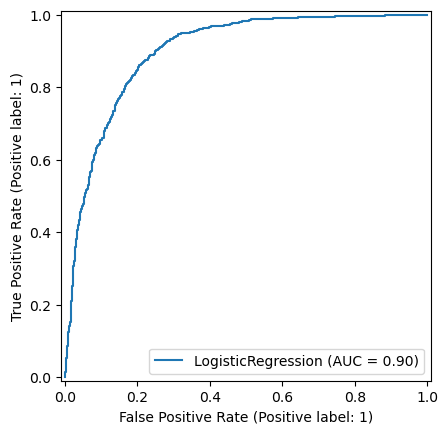

In [101]:
final_model = log_reg.fit(X_train_preprocessed, y_train)

RocCurveDisplay.from_estimator(final_model, X_test_preprocessed, y_test)

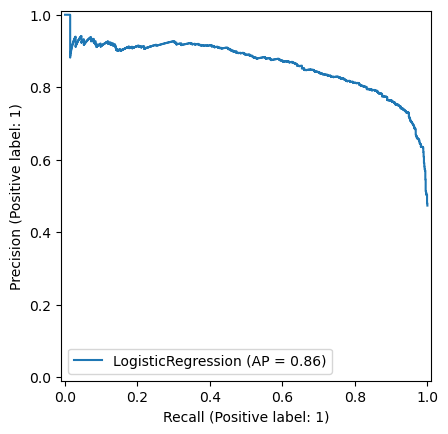

In [102]:
PrecisionRecallDisplay.from_estimator(final_model, X_test_preprocessed, y_test)

## F Beta Score

F1 Score is just a special case of F Beta score.

$ F_{beta} = (1 + \beta^2) \frac{precision*recall}{\beta^2 * precision + recall} $

If we care twice as much about recall, then we would use an F2 score where $\beta = 2$.

Interpreting Logistic Regression Coefficients

In [103]:
print('intercept ', log_reg.intercept_[0])
print('classes', log_reg.classes_)
pd.DataFrame({'coeff': log_reg.coef_[0],
              'odds_ratio' : np.exp(log_reg.coef_[0])}, 
             index=new_columns)

intercept  0.15651212356694413
classes [0 1]


,coeff,odds_ratio
num__age,-0.009492,0.990553
num__balance,0.090497,1.094718
num__day,0.058656,1.060411
num__duration,1.912581,6.770541
num__campaign,-0.279931,0.755836
num__pdays,-0.003561,0.996446
num__previous,0.081007,1.084378
cat__job_admin.,0.072560,1.075257
cat__job_blue-collar,-0.180053,0.835226
cat__job_entrepreneur,-0.123700,0.883645
